In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [12]:
with open('poker_add3.pkl', 'rb') as to_read:
    analysis_set2 = pickle.load(to_read)

analysis_set2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 60 non-null     int64  
 1   affluent_loss_prone       60 non-null     int64  
 2   chase_addict              60 non-null     int64  
 3   impulsive_behaviour_flag  60 non-null     int64  
 4   spike_inflation_%         60 non-null     float64
 5   age_classification        60 non-null     int64  
 6   selfexc_history           60 non-null     int64  
 7   latenight_session%        60 non-null     float64
 8   sum_net_result            60 non-null     int64  
 9   deposit_amount            60 non-null     int64  
dtypes: float64(2), int64(8)
memory usage: 4.8 KB


In [14]:
with open('poker_add2.pkl','rb') as to_read:
    analysis_set = pickle.load(to_read)

analysis_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                60 non-null     int64  
 1   age                      60 non-null     int64  
 2   gender                   60 non-null     int64  
 3   country                  60 non-null     object 
 4   deposit_amount           60 non-null     int64  
 5   avg_total_hands/session  60 non-null     int64  
 6   sum_net_result           60 non-null     int64  
 7   avg_buyin_amount         60 non-null     int64  
 8   avg_session_intensity    60 non-null     int64  
 9   avg_duration_hour        60 non-null     int64  
 10  chaseloss_count          60 non-null     int64  
 11  total_rounds             60 non-null     int64  
 12  total_loss%              60 non-null     float64
 13  income_levels            60 non-null     int64  
 14  age_class                60 

In [18]:
gmb_add = pd.merge(analysis_set2,analysis_set,on='player_id',how='left')
gmb_add.drop(columns={'latenight_session%_y','sum_net_result_y','deposit_amount_y'},axis=1, inplace = True)
gmb_add.columns
#analysis_set2.columns

Index(['player_id', 'affluent_loss_prone', 'chase_addict',
       'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
       'selfexc_history', 'latenight_session%_x', 'sum_net_result_x',
       'deposit_amount_x', 'age', 'gender', 'country',
       'avg_total_hands/session', 'avg_buyin_amount', 'avg_session_intensity',
       'avg_duration_hour', 'chaseloss_count', 'total_rounds', 'total_loss%',
       'income_levels', 'age_class', 'mean_mask', 'spike_inflation',
       'sum_latenight_hrs', 'sum_session_count'],
      dtype='object')

In [32]:
scaler = StandardScaler()
analysis_set_scaled = scaler.fit_transform(gmb_add)

In [33]:
pca = PCA(0.95)
x_pca = pca.fit_transform(gmb_add)
x_pca.shape

(60, 2)

In [34]:
pca.explained_variance_ratio_

array([0.86332888, 0.13460878])

In [36]:
features = ['player_id', 'affluent_loss_prone', 'chase_addict',
       'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
       'selfexc_history', 'latenight_session%_x', 'sum_net_result_x',
       'deposit_amount_x', 'gender', 'avg_total_hands/session',
       'avg_buyin_amount', 'avg_session_intensity', 'avg_duration_hour',
       'chaseloss_count', 'total_rounds', 'total_loss%', 'income_levels',
       'age_class', 'mean_mask', 'spike_inflation', 'sum_latenight_hrs',
       'sum_session_count' ]

# features = ['player_id', 'affluent_loss_prone', 'chase_addict',
#        'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
#        'selfexc_history', 'latenight_session%', 'cluster']


pca = PCA(0.95) # retain 95% of useful features and then create new dimenstions
x_pca = pca.fit_transform(gmb_add)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index= features)
print("\nTop contributors to PC1:\n", loadings['PC1'].abs().sort_values(ascending=False).head())
print("\nTop contributors to PC2:\n", loadings['PC2'].abs().sort_values(ascending=False).head())
#print("\nTop contributors to PC3:\n", loadings['PC3'].abs().sort_values(ascending=False).head())


Top contributors to PC1:
 deposit_amount_x     0.983076
sum_net_result_x     0.174731
avg_buyin_amount     0.053695
sum_session_count    0.009463
sum_latenight_hrs    0.004503
Name: PC1, dtype: float64

Top contributors to PC2:
 sum_net_result_x     0.981319
deposit_amount_x     0.178081
avg_buyin_amount     0.058213
sum_session_count    0.031046
sum_latenight_hrs    0.017905
Name: PC2, dtype: float64


# Kmean

In [37]:
X = gmb_add
x_scale = StandardScaler().fit_transform(X)
num_cluster = [i for i in range(2,11)]

def kmean_inertia(num_cluster, x_val):
    inertia = []
    for i in num_cluster:
        kms = KMeans(n_clusters = i, random_state=42)
        kms.fit(x_val)
        inertia.append(kms.inertia_)
    return inertia

inertia = kmean_inertia(num_cluster, x_scale)
inertia

[1002.7480788179407,
 839.6276019536077,
 753.8700106945021,
 712.809060183924,
 681.060961552417,
 644.3877199449097,
 594.8977088833491,
 565.0442075469614,
 537.5150940514857]

In [38]:
def Kmean_silscore(num_cluster, x_val):
    sil_score = []
    for i in num_cluster:
        kms = KMeans(n_clusters = i, random_state = 42)
        kms.fit(x_val)
        sil_score.append(silhouette_score(x_val, kms.labels_))
    return sil_score

sil_score = Kmean_silscore(num_cluster, X)
sil_score

[np.float64(0.49093537851965646),
 np.float64(0.43036477993816313),
 np.float64(0.3993001037566607),
 np.float64(0.39572422909570115),
 np.float64(0.3957126888732031),
 np.float64(0.3788210017994194),
 np.float64(0.34893508924815014),
 np.float64(0.3322466115656215),
 np.float64(0.3381496165245208)]

Text(0, 0.5, ' silhouette_score')

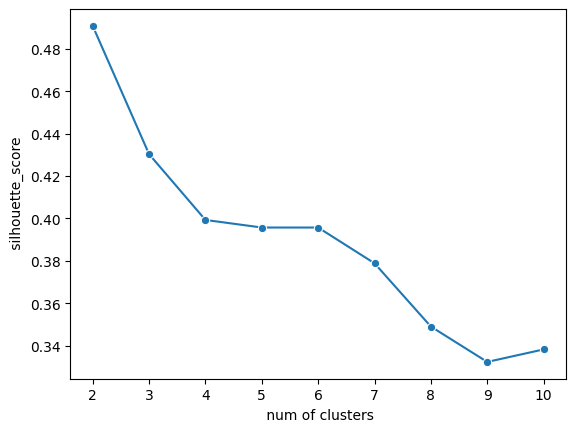

In [39]:
elbow = sns.lineplot(x= num_cluster, y = sil_score, marker = 'o')
elbow.set_xlabel(" num of clusters")
elbow.set_ylabel(" silhouette_score")

Text(0, 0.5, ' inertia')

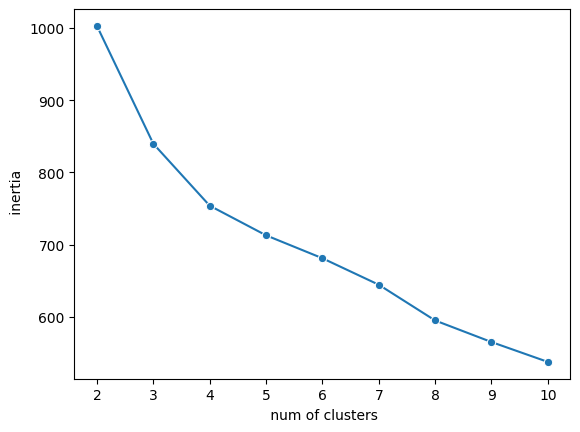

In [40]:
elbow = sns.lineplot(x= num_cluster, y = inertia, marker = 'o')
elbow.set_xlabel(" num of clusters")
elbow.set_ylabel(" inertia")

In [41]:
kms_cluster = KMeans(n_clusters=4, random_state=42)
kms_cluster.fit(X)

KMeans(n_clusters=4, random_state=42)

In [42]:
analysis_set2["cluster"] = kms_cluster.labels_
analysis_set2.groupby(by =['cluster','chase_addict','impulsive_behaviour_flag','age_classification','affluent_loss_prone','selfexc_history']).size()

cluster  chase_addict  impulsive_behaviour_flag  age_classification  affluent_loss_prone  selfexc_history
0        1             0                         1                   1                    0                  7
                                                                                          1                  1
                                                                                          2                  1
                       2                         1                   1                    0                  1
                       3                         1                   1                    0                  1
         2             0                         1                   1                    3                  1
                                                                     2                    2                  1
                       2                         1                   1                    1                  1
      

C:\Users\asingh\AppData\Local\Temp\ipykernel_9680\1690675442.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor = (1.3,1.0))


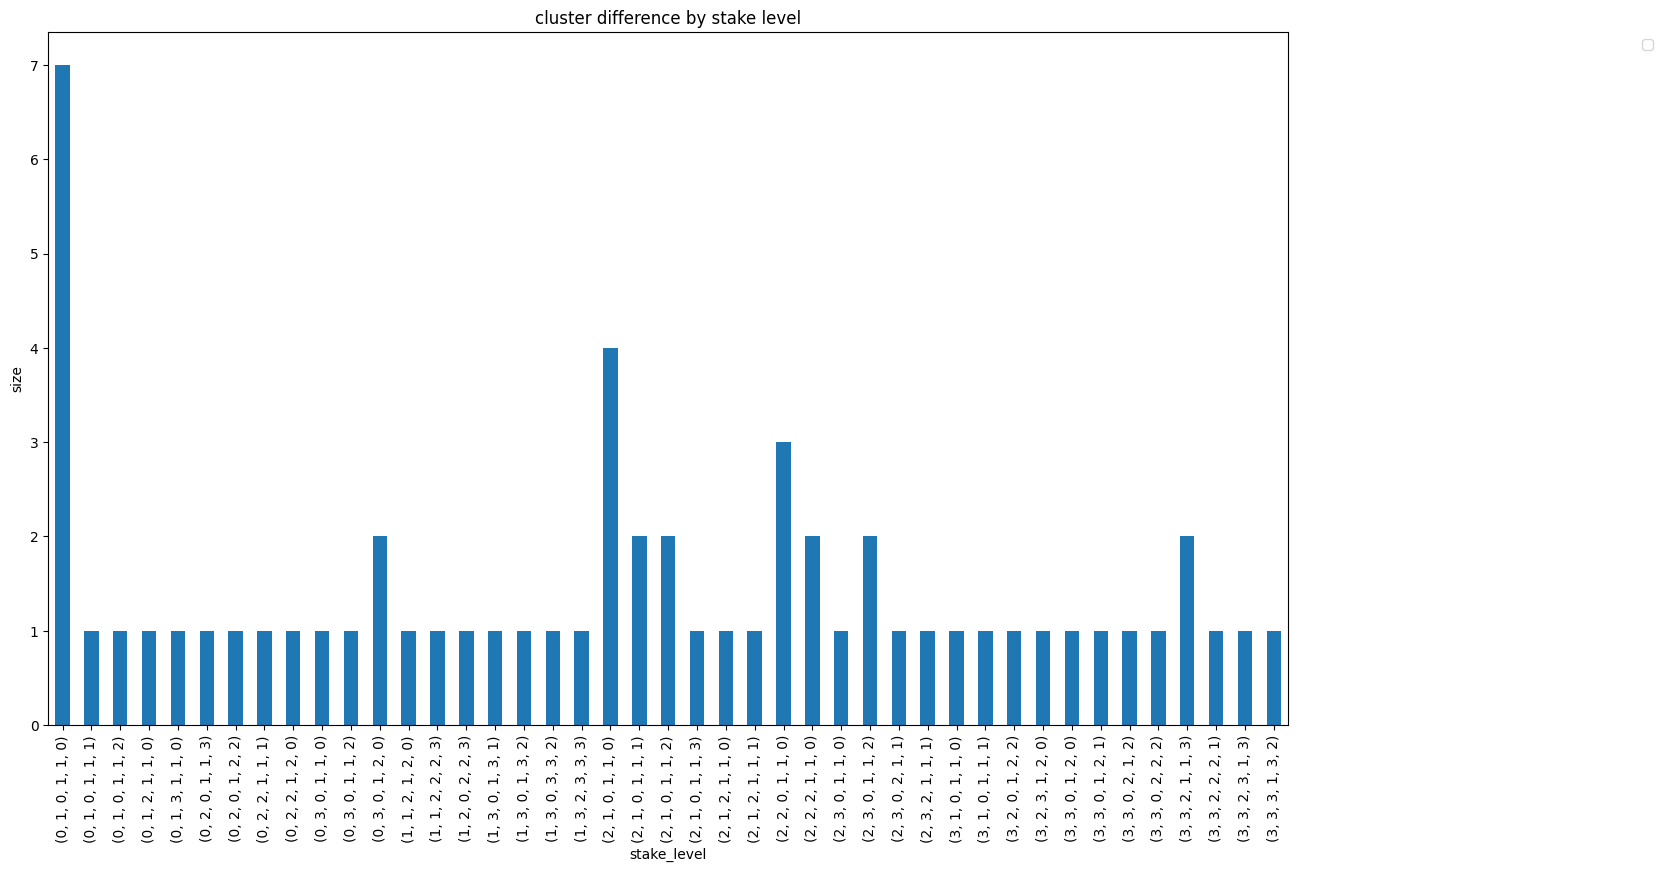

In [43]:
analysis_set2.groupby(by = ['cluster','chase_addict','impulsive_behaviour_flag','age_classification','affluent_loss_prone','selfexc_history']).size().plot.bar(title = "cluster difference by stake level",
                                                                                  figsize = (16,9),
                                                                                  ylabel ='size',
                                                                                  xlabel = 'stake_level')
plt.legend(bbox_to_anchor = (1.3,1.0))

In [44]:
score = cross_val_score(KMeans(n_clusters = 4,n_init=10,random_state=42),x_scale)
print(np.mean(score))
print(np.std(score))
score

-186.65726278097796
31.839809828372882


array([-186.2600608 , -212.7675664 , -182.48851364, -130.40155273,
       -221.36862033])

In [19]:
def calculate_risk_score(row):
    score = 0
    
    # affluent_loss_prone: 1=0, 2=1, 3=2
    if row['affluent_loss_prone'] == 1:
        score += 0
    elif row['affluent_loss_prone'] == 2:
        score += 1
    elif row['affluent_loss_prone'] == 3:
        score += 2
    
    # chase_addict: 1=0, 2=1, 3=2
    if row['chase_addict'] == 1:
        score += 0
    elif row['chase_addict'] == 2:
        score += 1
    elif row['chase_addict'] == 3:
        score += 2
    
    # impulsive_behaviour_flag: 0=0, 1=1, 2=2
    if row['impulsive_behaviour_flag'] == 2:
        score += 1
    elif row['impulsive_behaviour_flag'] == 3:
        score += 2
    else:
        score += row['impulsive_behaviour_flag']
    
    # spike_inflation_%: <40=0, 40-50=1, >50=2
    if row['spike_inflation_%'] < 40:
        score += 0
    elif 40 <= row['spike_inflation_%'] <= 60:
        score += 1
    else:
        score += 2
    
    # selfexc_history: 0=0, 1=1, 2=1, 3=2
    if row['selfexc_history'] == 1:
        score += 1
    elif row['selfexc_history'] == 2:
        score += 1
    elif row['selfexc_history'] == 3:
        score += 2
    else:
        score += row['selfexc_history']
    
    # latenight_session%: <10=0, 10-25=1, >25=2
    if row['latenight_session%_x'] < 10:
        score += 0
    elif 10 <= row['latenight_session%_x'] <= 25:
        score += 1
    else:
        score += 2
    
    # sum_net_result_x: positive=0, negative>-500=1, <=-500=2
    if row['sum_net_result_x'] > 0:
        score += 0
    elif row['sum_net_result_x'] > -500:
        score += 1
    else:
        score += 2
    
    # deposit_amount_x: <2000=0, 2000-4000=1, >4000=2
    if row['deposit_amount_x'] < 2000:
        score += 0
    elif 2000 <= row['deposit_amount_x'] <= 4000:
        score += 1
    else:
        score += 2
    
        
    # Calculate percentage (max score is 17) Total possible score: 0-17 (sum of max scores: 3+3+2+2+3+2+2+2+1).
    risk_percentage = (score / 17) * 100
    return round(risk_percentage, 2)

gmb_add['risk_percentage'] =gmb_add.apply(calculate_risk_score, axis=1)
az = gmb_add.sort_values(by='risk_percentage', ascending =False)
az

,player_id,affluent_loss_prone,chase_addict,impulsive_behaviour_flag,spike_inflation_%,age_classification,selfexc_history,latenight_session%_x,sum_net_result_x,deposit_amount_x,...,chaseloss_count,total_rounds,total_loss%,income_levels,age_class,mean_mask,spike_inflation,sum_latenight_hrs,sum_session_count,risk_percentage
28,1029,3,3,2,60.00,3,3,43.38,-2121,5000,...,12,30,63.33,3,5,5,18,59,136,82.35
35,1036,3,3,3,68.18,1,2,9.76,-810,3242,...,11,22,68.18,3,5,2,15,4,41,70.59
42,1043,3,3,0,48.28,3,2,45.11,-625,4245,...,12,29,65.52,3,4,5,14,60,133,70.59
3,1004,1,3,2,53.57,3,3,36.64,-1756,2589,...,12,28,64.29,1,3,5,15,48,131,64.71
45,1046,2,3,2,56.00,2,1,25.32,-534,3756,...,11,25,57.69,3,3,4,14,20,79,64.71
11,1012,3,3,0,45.83,1,2,31.25,-246,5000,...,11,24,62.50,3,3,3,11,20,64,64.71
57,1058,3,3,0,60.87,1,1,9.52,-1161,4816,...,12,23,65.22,3,5,2,14,4,42,64.71
53,1054,2,2,0,47.83,2,3,29.17,-653,4657,...,9,23,52.17,3,5,4,11,21,72,64.71
33,1034,1,3,2,53.85,1,3,24.64,-735,3316,...,12,26,65.38,1,3,3,14,17,69,58.82
46,1047,2,3,0,50.00,2,2,34.62,-1012,3064,...,11,26,53.85,2,5,4,13,36,104,58.82


In [20]:
gmb_add.columns

Index(['player_id', 'affluent_loss_prone', 'chase_addict',
       'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
       'selfexc_history', 'latenight_session%_x', 'sum_net_result_x',
       'deposit_amount_x', 'age', 'gender', 'country',
       'avg_total_hands/session', 'avg_buyin_amount', 'avg_session_intensity',
       'avg_duration_hour', 'chaseloss_count', 'total_rounds', 'total_loss%',
       'income_levels', 'age_class', 'mean_mask', 'spike_inflation',
       'sum_latenight_hrs', 'sum_session_count', 'risk_percentage'],
      dtype='object')

In [21]:
short_list = gmb_add.groupby('player_id')[['affluent_loss_prone', 'chase_addict','impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
                     'selfexc_history', 'latenight_session%_x', 'sum_net_result_x','deposit_amount_x','age', 'gender', 'country', 'avg_total_hands/session',
                     'avg_buyin_amount','risk_percentage']].agg(lambda x: x).reset_index()
short_list

,player_id,affluent_loss_prone,chase_addict,impulsive_behaviour_flag,spike_inflation_%,age_classification,selfexc_history,latenight_session%_x,sum_net_result_x,deposit_amount_x,age,gender,country,avg_total_hands/session,avg_buyin_amount,risk_percentage
0,1001,1,1,0,52.38,1,2,32.61,-618,1128,56,0,US,50,165,35.29
1,1002,1,2,0,40.91,1,0,13.89,-325,1103,69,0,DE,53,138,23.53
2,1003,1,3,2,57.69,1,1,14.29,172,1656,46,1,DE,49,149,35.29
3,1004,1,3,2,53.57,3,3,36.64,-1756,2589,32,1,UK,38,318,64.71
4,1005,1,1,0,42.86,1,1,18.18,-72,2075,60,0,US,48,170,29.41
5,1006,1,1,0,38.10,1,1,29.41,178,1103,25,1,DE,47,146,17.65
6,1007,1,2,2,54.17,1,0,8.89,-52,1295,78,1,US,54,145,23.53
7,1008,1,1,0,46.43,1,3,7.02,363,1569,38,1,CA,43,136,17.65
8,1009,1,3,2,52.17,1,3,13.33,-545,3087,56,1,IN,46,191,58.82
9,1010,2,3,0,48.15,1,0,20.31,-141,2785,75,0,UK,47,217,41.18
